# Michaelis-Menten Model Calibration Example

In [1]:
import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import copy

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import os 

SEED=123456
np.random.seed(seed=SEED)
engine = eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

MODEL_SBML_FILE = "model_sbml.xml"
SPECIES = ["S", "E", "ES", "P"]
SPECIES_IDs = ["S1", "S2", "S3", "S4"] # how the species ids are saved in the SBML file from the original BNGL model
SPECIES_COLORS = ["r", "b", "indigo", "g"]
PARAMS = ["log_k1", "log_k2", "log_k3"]

LOG_ERROR = False

8


### Load experimental data used to calibrate model
From here: https://github.com/RuleWorld/ptempest/tree/master/examples/michment

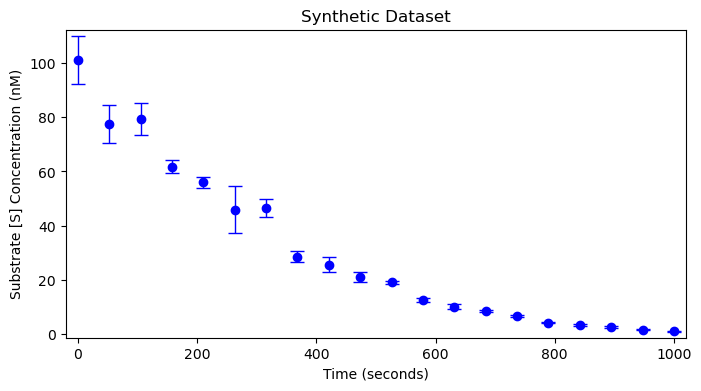

In [2]:
data = io.loadmat("MM.mat")["expt"]
data = data.ravel()[0][0]
ts = data["time"][0].flatten()
means = data["mean"][0]
means = means[~(pd.isnull(means))]
stds = data["stdev"][0]
stds = stds[~(pd.isnull(stds))]
labels = data["obsv_labels"][0][0]
labels = [x[0] for x in labels]
init_conds = [data["S0"][0][0][0], data["E0"][0][0][0]]

plt.figure(figsize=(8,4)),
plt.errorbar(ts, means, yerr=stds, capsize=5, c="b", lw=0, marker="o", elinewidth=1);
plt.xlabel("Time (seconds)"); plt.ylabel("Substrate [S] Concentration (nM)");
plt.margins(x=0.02, y=0.02);
plt.title("Synthetic Dataset");

### Load model using `libroadrunner`

**WARNING!** - Changing the initial conditions after changing parameter values will <ins>RESET</ins> the parameter to its original value! Example shown below.

In [3]:
rr = roadrunner.RoadRunner(MODEL_SBML_FILE)
rr.integrator.absolute_tolerance = 5e-10
rr.integrator.relative_tolerance = 1e-8

#rr["init([S1])"] = float(init_conds[0]) # change initial substrate concentration
#rr["init([S2])"] = float(init_conds[1]) # change initial enzyme concentration

In [4]:
print("This is the original value of log_k2 parameter upon loading the model into Python.")
print("\tOriginal value of log_k2: %1.1f"%rr["log_k2"])

rr["log_k2"] = -5
print("\nNow, this value should be -5 since we changed it.")
print("\tPost-change, pre-initial condition change log_k2 value: ", rr["log_k2"])

#rr["init([S1])"] = float(init_conds[0]) # change initial substrate concentration
#rr["init([S2])"] = float(init_conds[1]) # change initial enzyme concentration

print("\nWe would expect this to stay as -5 but it is reset to its original value when we loaded the SBML file.")
print("\tPost-change, post-initial condition change log_k2 value: ", rr["log_k2"])

# change parameter value again and test reset 
rr["log_k2"] = -5

# From documentation
# rr.reset resets time, all floating species, and rates to their initial values. Does NOT reset changed global parameters.
rr.reset()
print("\nDifferent model values post-reset (for clarification purposes): ")
print("\tIntegrator absolute tolerance: ", rr.integrator.absolute_tolerance)
print("\tInitial substrate concentration: ", rr["init([S1])"])
print("\tParameter log_k2 value:", rr.getValue("log_k2"))

This is the original value of log_k2 parameter upon loading the model into Python.
	Original value of log_k2: 0.0

Now, this value should be -5 since we changed it.
	Post-change, pre-initial condition change log_k2 value:  -5.0

We would expect this to stay as -5 but it is reset to its original value when we loaded the SBML file.
	Post-change, post-initial condition change log_k2 value:  -5.0

Different model values post-reset (for clarification purposes): 
	Integrator absolute tolerance:  5e-10
	Initial substrate concentration:  100.0
	Parameter log_k2 value: -5.0


### Define helper functions that change model parameters and simulate model

log_k1 PRE-CHANGE IN MODEL:  -4.6052
log_k1 -10.0 -10.0
log_k2 PRE-CHANGE IN MODEL:  0.0
log_k2 -10.0 -10.0
log_k3 PRE-CHANGE IN MODEL:  0.0
log_k3 -10.0 -10.0


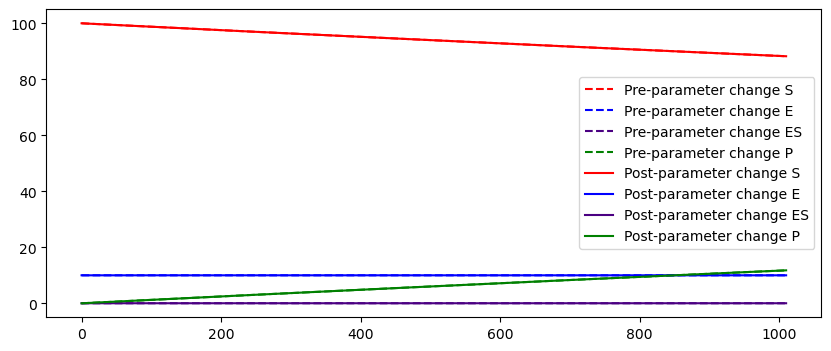

In [7]:
def change_and_run(new_params):
    rr.reset()
    #rr["init([S1])"] = float(init_conds[0]) # change initial substrate concentration
    #rr["init([S2])"] = float(init_conds[1]) # change initial enzyme concentration
    for name,val in zip(PARAMS, new_params):
        print(name, "PRE-CHANGE IN MODEL: ",  rr[name])
        rr[name] = val
        print(name, val, rr[name])
    try:
        res = rr.simulate(0, 1010, 10100)
        #print(res)
    except:
        res = []
    return res

rr.resetAll()
plt.figure(figsize=(10,4))
orig_traj = rr.simulate(0,1010,10100)
orig_ts = orig_traj[:, 0]
orig_specs = np.transpose(orig_traj[:, 1:])
for cur_label, cur_traj, cur_c in zip(SPECIES, orig_specs, SPECIES_COLORS):
    plt.plot(orig_ts, cur_traj, c=cur_c, label="Pre-parameter change %s"%cur_label, linestyle="--")
plt.legend();

# sanity check by setting all parameters to near 0
traj = change_and_run([-10.0, -10.0, -10.0])
traj_ts = traj[:, 0]
traj_specs = np.transpose(traj[:, 1:])

for cur_label, cur_traj, cur_c in zip(SPECIES, traj_specs, SPECIES_COLORS):
    plt.plot(traj_ts, cur_traj, c=cur_c, label="Post-parameter change %s"%cur_label)
plt.legend();
